# 降水预测

## 所需库

In [1]:
# 数据模型
import pandas as pd

# 绘图
import matplotlib.pyplot as plt

# 数值计算
import numpy as np

# 数据可视化
import seaborn as sns
import plotly.express as px

from math import sqrt
import warnings
warnings.filterwarnings("ignore")


### 训练模型所需库

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


## 数据准备(Data preparation)

### 导入数据

In [ ]:
train = pd.read_csv('weatherAUS.csv')
#预览
train

注: WindGustDir为24小时内最大风力风向, WindGustSpeed为24小时内最大风速. 

### 数据概览

首先考察数据集的行数和列数. 

In [ ]:
#获取数据集的行数和列数
train.shape

(145460, 23)

然后考察数据集大小, 并据此考虑是否需要在大小上进行压缩. 

In [ ]:
#获取数据集所有列的统计数据
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

对比可以得出, 数据已成功自weatherAUS.csv文件中导入, 且行数和列数正确. 其中, RainTomorrow就是我们的**预测目标变量**(target variable to predict). 

### 数据检索和清洗

#### 数据检索(Data retrieving)

现在, 我们对RainToday和RainTomorrow两者进行图表制作并探索他们之间的关系

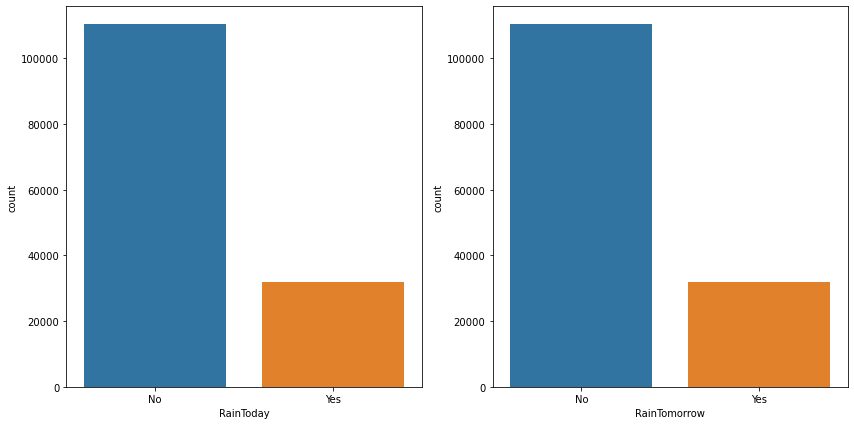

In [ ]:
plt.figure(figsize = (14, 7))
#第一个子图
plt.subplot(1, 2, 1)
sns.countplot(x = 'RainToday', data = train)
#第二个子图
plt.subplot(1, 2, 2)
sns.countplot(x = 'RainTomorrow', data = train)
plt.show()

由于RainToday和RainTomorrow都是真/假对象, 为方便起见, 我们将它们转换为1和0.  
并且, 可以发现, 0和1的出现次数之比大约是78:22, 即在RainTomorrow之中存在着**分类不平衡**(class imbalance). 因此. 我们需要在少数类中使用**过采样**(oversampling). 相对地, 考虑到数据有限, 不考虑**欠采样**(undersampling). 

In [ ]:
#将Yes/No转换为1/0
#inplace = True -> 不创建新的对象, 直接对原对象进行修改
train['RainToday'].replace({'No': 0, 'Yes': 1}, inplace = True)
train['RainTomorrow'].replace({'No': 0, 'Yes': 1}, inplace = True)

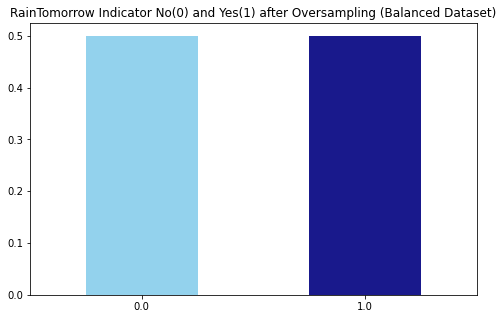

In [ ]:
#处理分类不平衡

no = train[train.RainTomorrow == 0]
yes = train[train.RainTomorrow == 1]
#对yes进行过采样
yes_oversampled = resample(yes, replace = True, n_samples = len(no), random_state = 123)
#数据合并
train = pd.concat([no, yes_oversampled])
#绘图
fig = plt.figure(figsize = (8,5))
train.RainTomorrow.value_counts(normalize = True).plot(kind = 'bar', color = ['skyblue', 'navy'], alpha = 0.9, rot = 0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

#### 数据清洗(Data cleaning)

##### 处理日期时间格式

这里, 我们要将Date一列的dtypes转换为日期时间格式, 并消去原时间, 只保留year, month, day的值. 

In [ ]:
#将Date一列转换为日期时间格式
train['Date'] = pd.to_datetime(train['Date'])

#将该列分为year, month, day三列, 并舍弃该列
train['year'] = train.Date.apply(lambda x: x.year)
train['month'] = train.Date.apply(lambda x: x.month)
train['day'] = train.Date.apply(lambda x: x.day)
train.drop(columns = ['Date'], axis = 1, inplace = True)

#预览变化
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220632 entries, 0 to 27220
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       220632 non-null  object 
 1   MinTemp        219550 non-null  float64
 2   MaxTemp        220161 non-null  float64
 3   Rainfall       217508 non-null  float64
 4   Evaporation    125221 non-null  float64
 5   Sunshine       115801 non-null  float64
 6   WindGustDir    205141 non-null  object 
 7   WindGustSpeed  205278 non-null  float64
 8   WindDir9am     205904 non-null  object 
 9   WindDir3pm     214192 non-null  object 
 10  WindSpeed9am   218426 non-null  float64
 11  WindSpeed3pm   216279 non-null  float64
 12  Humidity9am    217461 non-null  float64
 13  Humidity3pm    214601 non-null  float64
 14  Pressure9am    198904 non-null  float64
 15  Pressure3pm    198886 non-null  float64
 16  Cloud9am       139293 non-null  float64
 17  Cloud3pm       135018 non-null

对比前面的表格, 可以看出, object类型的Date已经被int64类型的year, month, day取代. 

##### 删去列中前后空格

In [ ]:
train_cols = train.select_dtypes(['object']).columns
train[train_cols] = train[train_cols].apply(lambda x: x.str.strip())

##### 将所有文字变为小写

In [ ]:
train = train.applymap(lambda s: s.lower() if type(s) == str else s)
train.columns = train.columns.str.strip().str.lower()

#预览变化
train

,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,...,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow,year,month,day
0,albury,13.4,22.9,0.6,NaN,NaN,w,44.0,w,wnw,...,1007.1,8.0,NaN,16.9,21.8,0.0,0.0,2008,12,1
1,albury,7.4,25.1,0.0,NaN,NaN,wnw,44.0,nnw,wsw,...,1007.8,NaN,NaN,17.2,24.3,0.0,0.0,2008,12,2
2,albury,12.9,25.7,0.0,NaN,NaN,wsw,46.0,w,wsw,...,1008.7,NaN,2.0,21.0,23.2,0.0,0.0,2008,12,3
3,albury,9.2,28.0,0.0,NaN,NaN,ne,24.0,se,e,...,1012.8,NaN,NaN,18.1,26.5,0.0,0.0,2008,12,4
4,albury,17.5,32.3,1.0,NaN,NaN,w,41.0,ene,nw,...,1006.0,7.0,8.0,17.8,29.7,0.0,0.0,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133585,launceston,1.1,11.8,0.4,NaN,NaN,wnw,13.0,NaN,NaN,...,1013.3,NaN,NaN,4.0,9.5,0.0,1.0,2010,6,8
117307,pearceraaf,9.6,14.8,11.8,NaN,4.3,w,69.0,wnw,wsw,...,1015.7,8.0,8.0,11.4,12.6,1.0,1.0,2016,8,8
87307,cairns,24.8,31.5,0.0,5.4,3.4,se,48.0,sse,ese,...,1006.2,5.0,6.0,28.7,30.3,0.0,1.0,2009,3,18
56427,ballarat,4.2,7.9,11.4,NaN,NaN,sw,63.0,nnw,ssw,...,998.9,8.0,8.0,4.6,6.8,1.0,1.0,2012,8,17


##### 检查数据集中缺失的数据

In [ ]:
#缺失数据数
missing = pd.DataFrame(train.isnull().sum(), columns = ['no. of missing values'])
#缺失数据占比, 精确到1%
missing['% missing_values'] = (missing / len(train)).round(2) * 100
#预览
missing

,no. of missing values,% missing_values
location,0,0.0
mintemp,1082,0.0
maxtemp,471,0.0
rainfall,3124,1.0
evaporation,95411,43.0
sunshine,104831,48.0
windgustdir,15491,7.0
windgustspeed,15354,7.0
winddir9am,14728,7.0
winddir3pm,6440,3.0


从上表可以看出, evaporation, sunshine, cloud9am, cloud3pm等特征是有很大一部分数据缺失的. 下面对这四个特征进行缺失数据的检查. 

In [ ]:
#降序排列
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum() / train.isnull().count()).sort_values(ascending = False)
missing = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing.head(4)

,Total,Percent
sunshine,104831,0.475140
evaporation,95411,0.432444
cloud3pm,85614,0.388040
cloud9am,81339,0.368664


经过观察, 我们发现这四列数据有着低于50%的数据缺失率. 比起直接完全放弃考虑这些参数, 我们会考虑使用适当的方法来将它们纳入模型之中. 我们提取数值特征, 分析它们的分配情况, 并据此决定使用**中位数**(median)还是**均值**(mean), 或是舍弃缺失值. 

In [ ]:
#提取数值特征
num_col = train.select_dtypes(include = np.number).columns.to_list()
len(num_col)

21

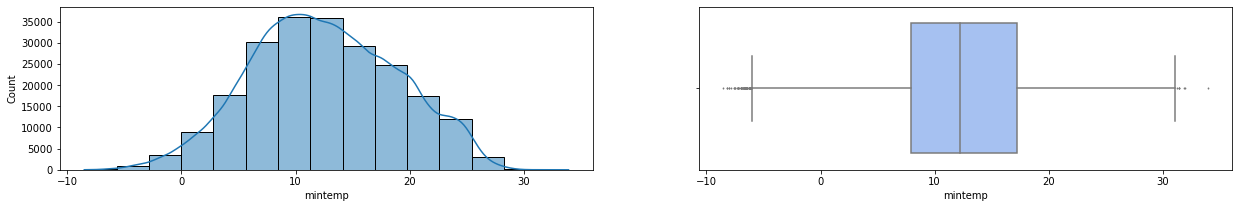

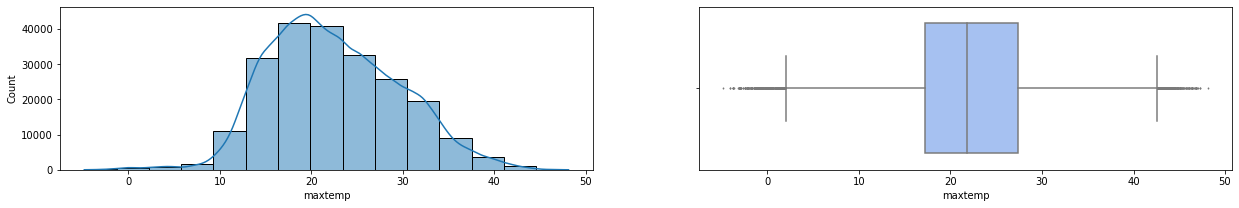

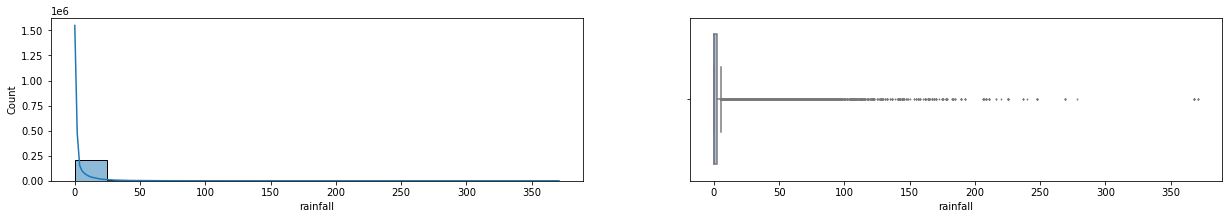

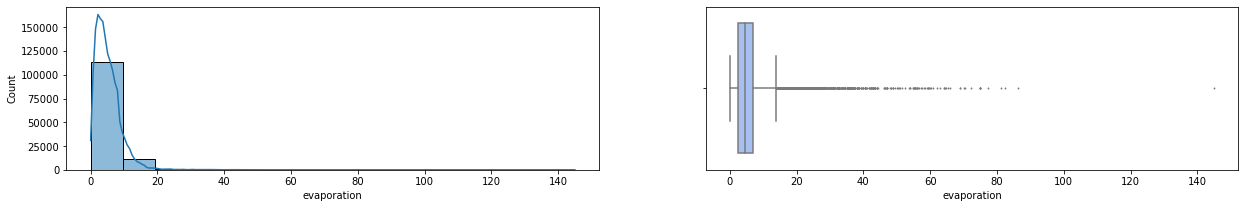

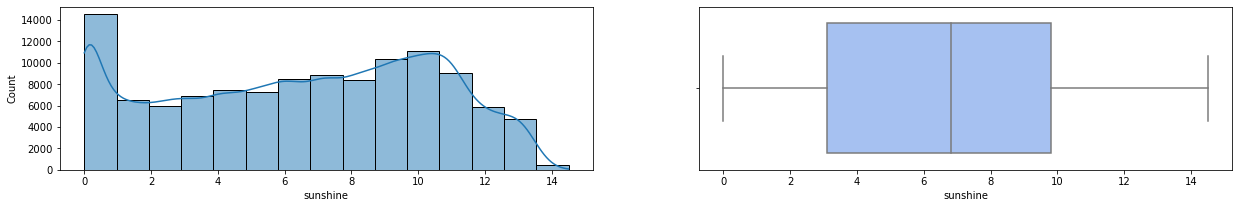

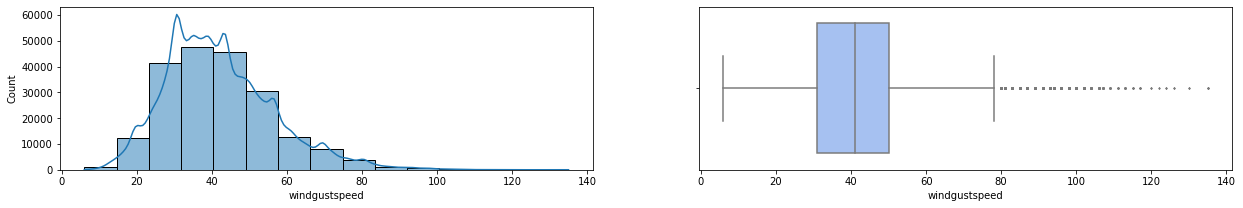

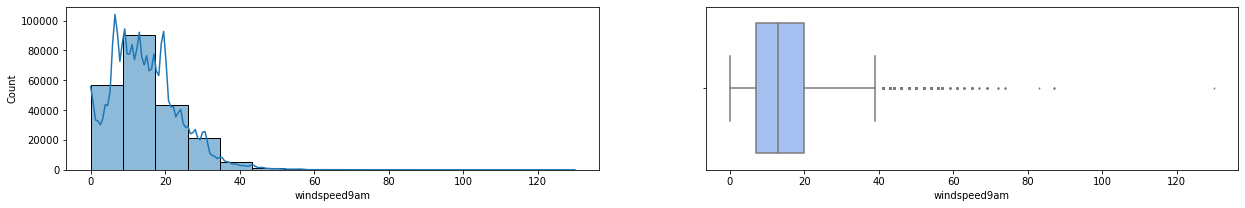

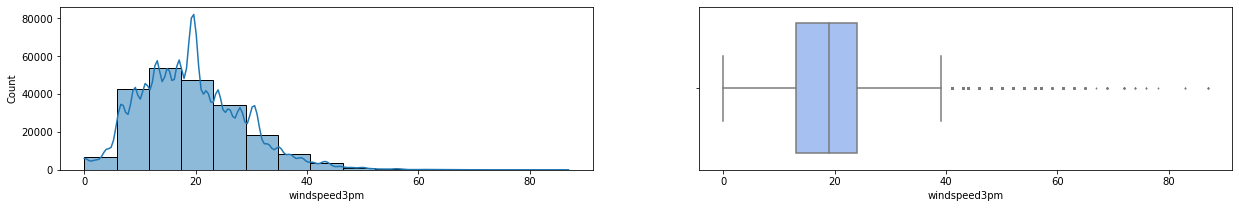

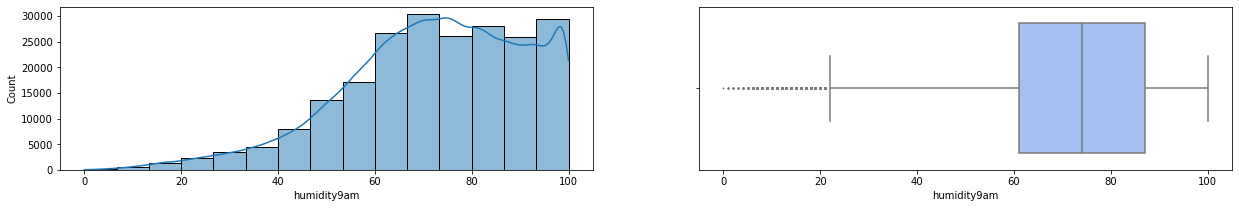

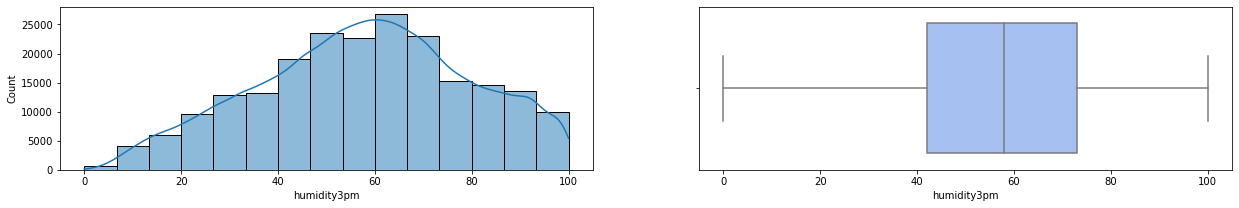

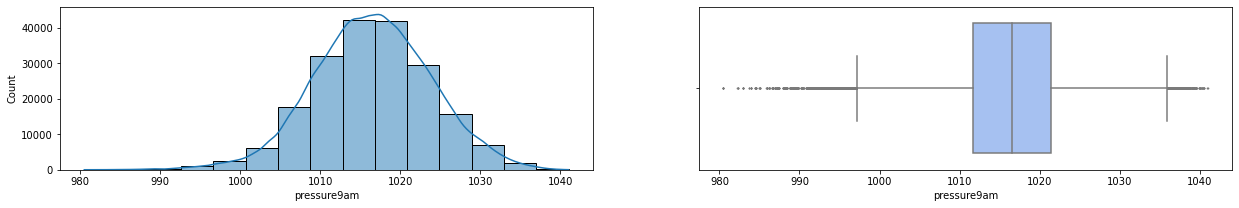

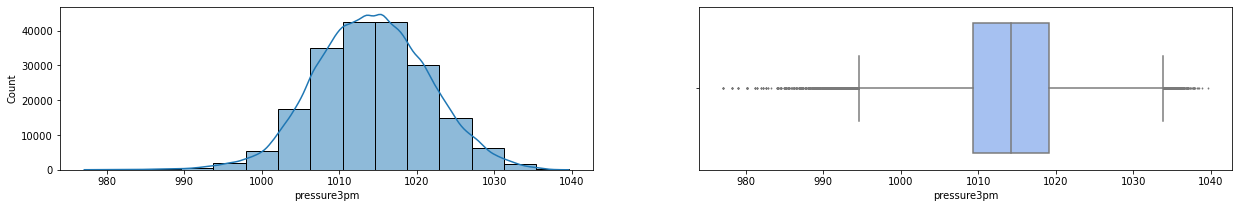

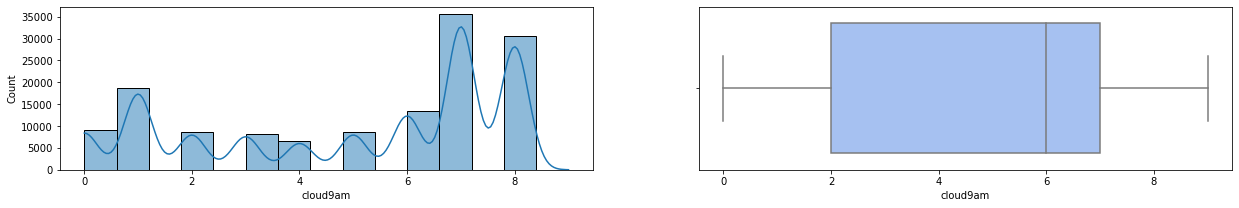

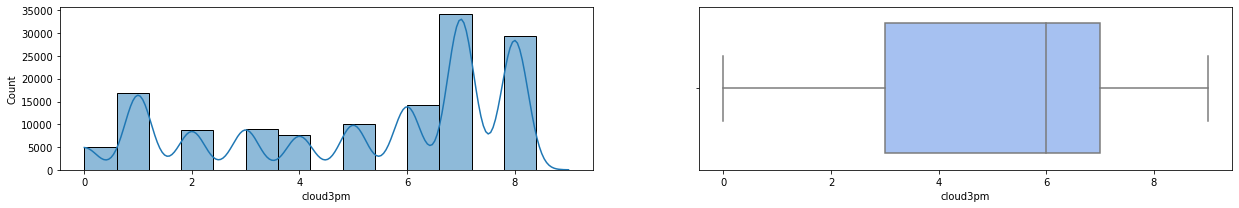

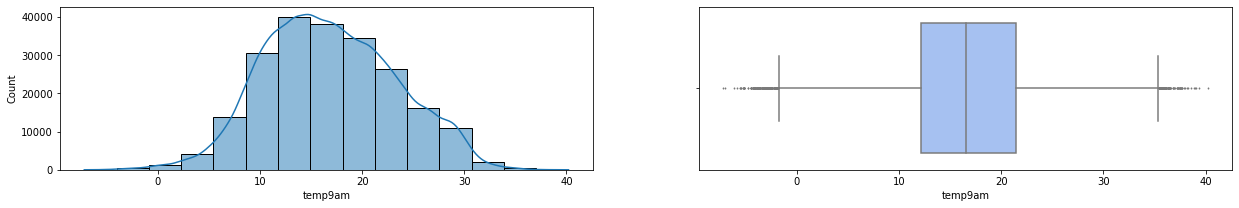

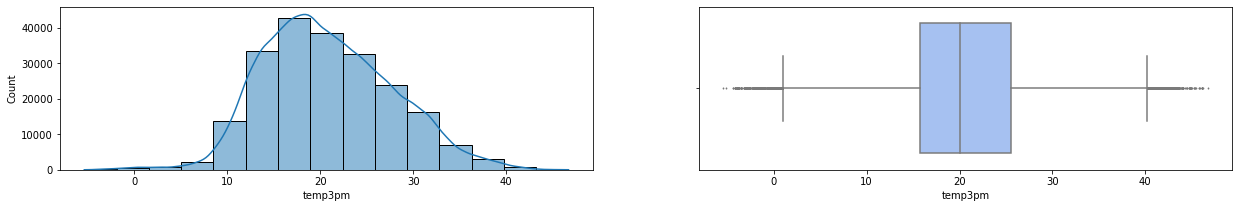

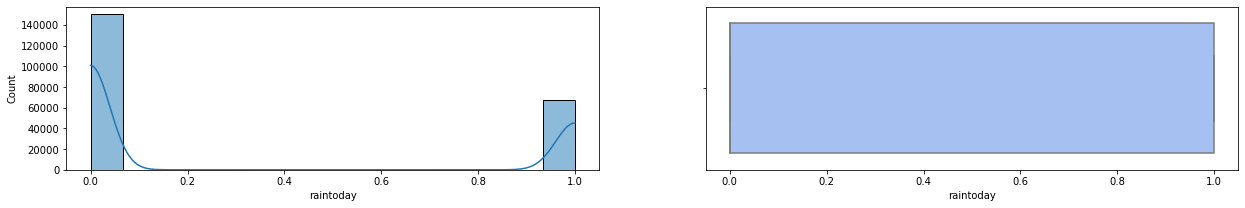

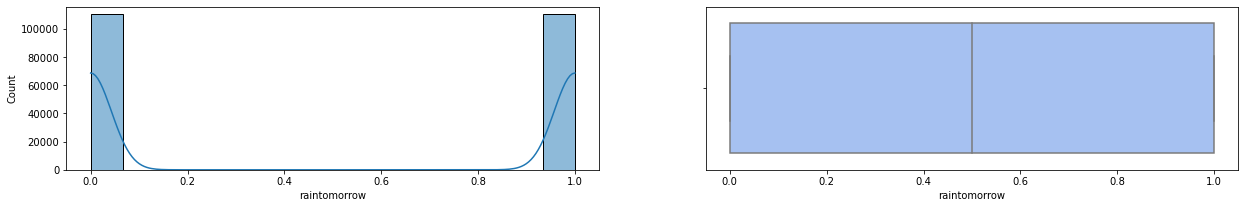

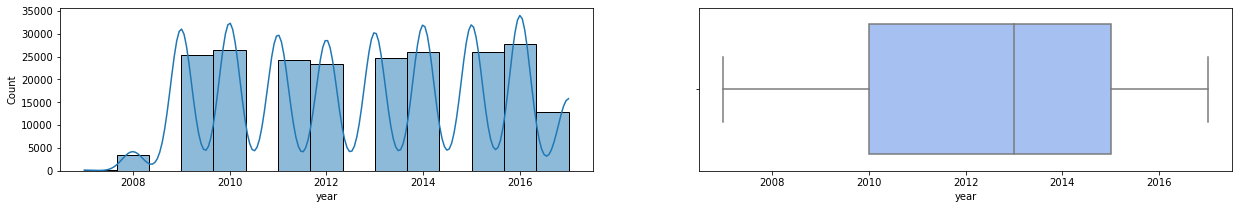

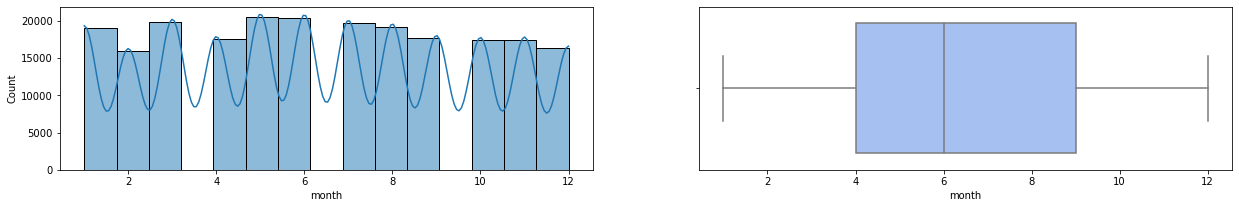

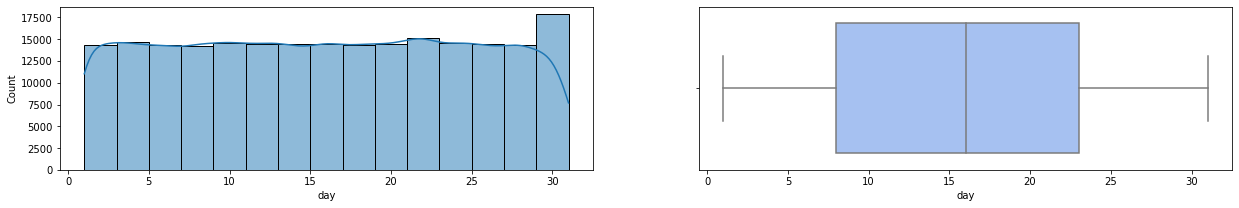

In [ ]:
#绘制直方图和箱形图
for i in num_col:
    fig, axs = plt.subplots(1, 2, figsize = (21, 3));
    sns.histplot(train[i], bins = 15, kde = True, ax = axs[0]);
    sns.boxplot(train[i], ax = axs[1], color = '#99befd', fliersize = 1);

由于缺失的数据较多, 我们选择舍弃缺失值. 

In [ ]:
train = train.dropna()

#预览变化
train.isna().sum()

location         0
mintemp          0
maxtemp          0
rainfall         0
evaporation      0
sunshine         0
windgustdir      0
windgustspeed    0
winddir9am       0
winddir3pm       0
windspeed9am     0
windspeed3pm     0
humidity9am      0
humidity3pm      0
pressure9am      0
pressure3pm      0
cloud9am         0
cloud3pm         0
temp9am          0
temp3pm          0
raintoday        0
raintomorrow     0
year             0
month            0
day              0
dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87015 entries, 6049 to 87307
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location       87015 non-null  object 
 1   mintemp        87015 non-null  float64
 2   maxtemp        87015 non-null  float64
 3   rainfall       87015 non-null  float64
 4   evaporation    87015 non-null  float64
 5   sunshine       87015 non-null  float64
 6   windgustdir    87015 non-null  object 
 7   windgustspeed  87015 non-null  float64
 8   winddir9am     87015 non-null  object 
 9   winddir3pm     87015 non-null  object 
 10  windspeed9am   87015 non-null  float64
 11  windspeed3pm   87015 non-null  float64
 12  humidity9am    87015 non-null  float64
 13  humidity3pm    87015 non-null  float64
 14  pressure9am    87015 non-null  float64
 15  pressure3pm    87015 non-null  float64
 16  cloud9am       87015 non-null  float64
 17  cloud3pm       87015 non-null  float64
 18  tem

至此, 数据已经清洗完毕, 可以用于分析和训练模型. 

## 数据浏览(Data exploration)

### 通过适当的统计方法分析数据

> 首先, 我们需要完成以下任务:
> + 计算rainfall, sunshine, temp3pm, temp9am的均值;
> + 计算rainfall, sunshine, temp3pm, temp9am的标准差;
> + 分析windgustdir的分配比例.

5875
5491
4012
5319
6942
5768
5560
4617
6277
6061
7010
3836
4744
4964
6041
4498


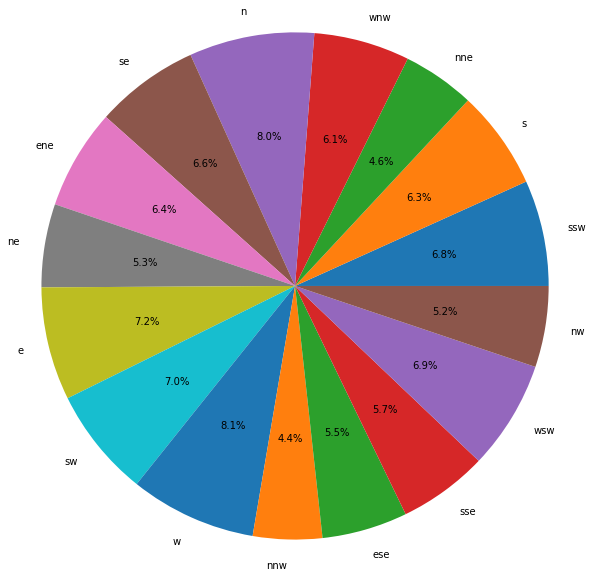

In [ ]:
df = train
rainfall_array = df[['rainfall']].to_numpy()
sunshine_array = df[['sunshine']].to_numpy()
temp3pm_array = df[['temp3pm']].to_numpy()
temp9am_array = df[['temp9am']].to_numpy()
windgustdir_array = np.squeeze(df[['windgustdir']].to_numpy())

#均值
rainfall_mean = np.mean(rainfall_array)
sunshine_mean = np.mean(sunshine_array)
temp3pm_mean = np.mean(temp3pm_array)
temp9am_mean = np.mean(temp9am_array)

#标准差
rainfall_std = np.std(rainfall_array)
sunshine_std = np.std(sunshine_array)
temp3pm_std = np.std(temp3pm_array)
temp9am_std = np.std(temp9am_array)

#计算windgustdir的各项占比
wind_direction_map = {}

#遍历windgustdir数组中的每个元素
for direction in windgustdir_array:
    #若该风向已经存在于map中, 则数量+1;
    if direction in wind_direction_map:
        wind_direction_map[direction] += 1
    #否则, 初始化其数量为1
    else:
        wind_direction_map[direction] = 1

#各个风向
directions = wind_direction_map.keys()
counts = []
for direction in directions:
    print(wind_direction_map.get(direction))
    counts.append(wind_direction_map.get(direction))


#绘制饼状图
labels = directions
sizes = counts
fig, ax = plt.subplots()
ax.pie(sizes, labels = labels, autopct = '%1.1f%%')
#equal保证了饼状图的形状是圆形
ax.axis('equal')
fig.set_size_inches(10, 10)

#展示饼状图
plt.show()

可以得知, windgustdir这一项数据是基本上平均分布的, 没有异常或者主导风向. 

  
现在, 我们需要对temp9am, temp3pm, sunshine, rainfall这几项数据绘制直方图并进行分析. 

#### 绘制temp9am的直方图

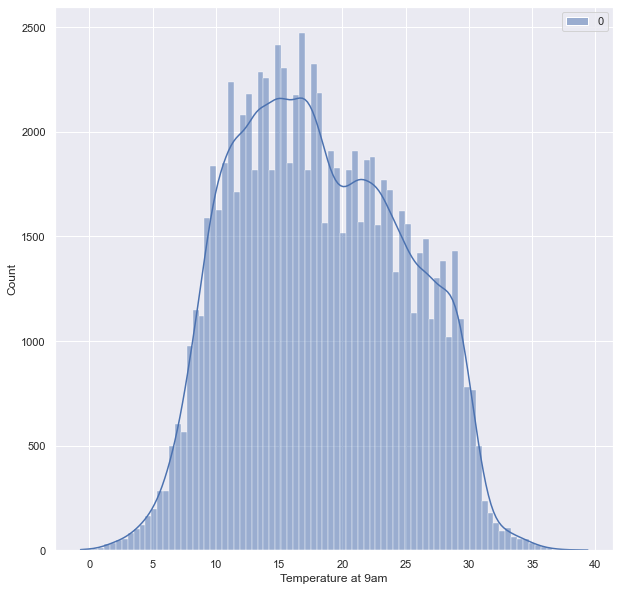

Mean of temperature at 9am:  18.132615066367865
Standard deviation of temperature at 9am:  6.570867709722627


In [ ]:
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
sns.histplot(data = temp9am_array, kde = True)
plt.xlabel("Temperature at 9am")
fig.set_size_inches(10, 10)
plt.show()
print("Mean of temperature at 9am: ", temp9am_mean)
print("Standard deviation of temperature at 9am: ", temp9am_std)

可以得知, temp9am一项数据大致服从**正态分布**(normal distribution), 没有明显的**离群值**(visable outlier). 期望值为(18 ± 6)°C, 是符合当地情况的.

#### 绘制temp3pm的直方图

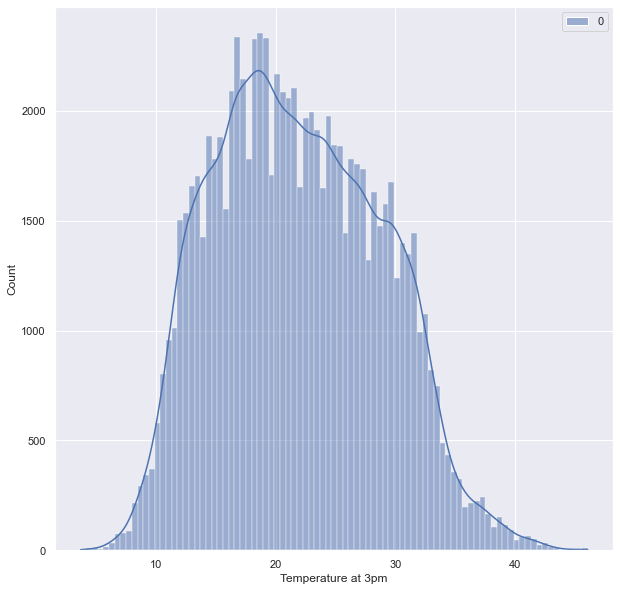

Mean of temperature at 3pm:  21.87791989886801
Standard deviation of temperature at 9am:  6.881076407136402


In [ ]:
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
sns.histplot(data = temp3pm_array, kde = True)
plt.xlabel("Temperature at 3pm")
fig.set_size_inches(10, 10)
plt.show()
print("Mean of temperature at 3pm: ", temp3pm_mean)
print("Standard deviation of temperature at 9am: ", temp3pm_std)

可以得知, temp3pm一项数据大致服从正态分布, 没有明显的离群值. 期望值为(22 ± 7)°C, 这高于temp9am的期望值. 考虑到阳光在3pm应当比在9am更多, 这也是符合当地情况的. 

#### 绘制sunshine的直方图

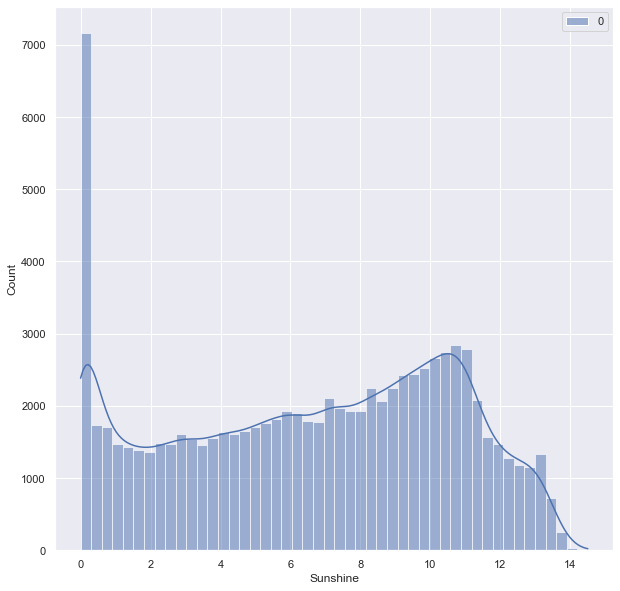

Mean of sunshine:  6.603815434120554
Standard deviation of sunshine:  3.943706613070807


In [ ]:
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
sns.histplot(data = sunshine_array, kde = True)
plt.xlabel("Sunshine")
fig.set_size_inches(10, 10)
plt.show()
print("Mean of sunshine: ", sunshine_mean)
print("Standard deviation of sunshine: ", sunshine_std)

可以得知, sunshine这一项数据大致服从**双峰分布**(bimodal distribution). 考虑到澳大利亚在多云天气下或冬季可能没有阳光, 0处的峰值是合理的. 

#### 绘制rainfall的直方图

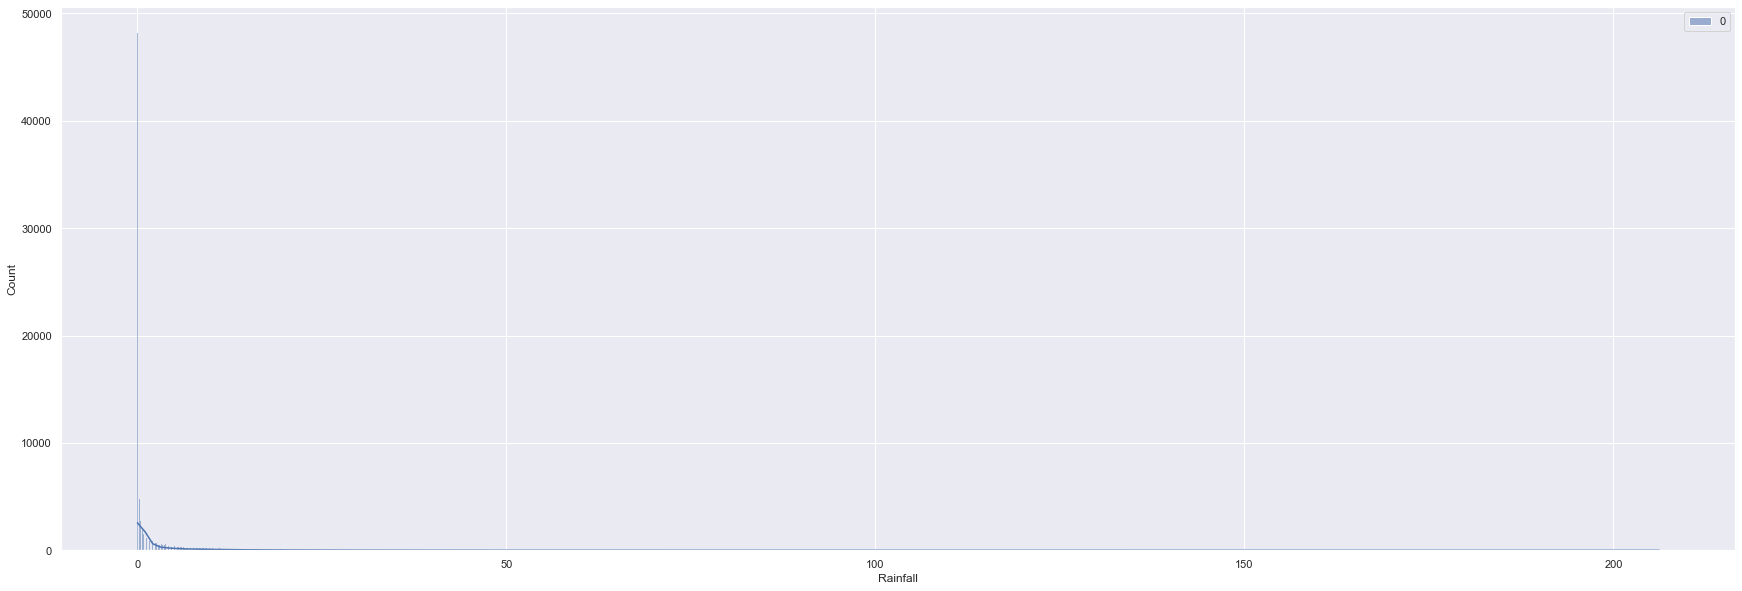

Mean of Rainfall:  3.304891110728035
Standard deviation of Rainfall:  9.025804120093015
Max Rainfall value:  206.2


In [ ]:
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
sns.histplot(data = rainfall_array, kde = True)
plt.xlabel("Rainfall")
fig.set_size_inches(30, 10)
plt.show()
print("Mean of Rainfall: ", rainfall_mean)
print("Standard deviation of Rainfall: ", rainfall_std)
print("Max Rainfall value: ", np.max(rainfall_array))

可以得知, rainfall这一项数据在0处有峰值. 这意味着, 在大多数日子, 澳大利亚是没有雨的. 即使下雨了, 平均降水量也只有3.3mm. 另一方面, 数据集中的最大降雨量却有206.2mm.  
尽管看起来不太正确, 这样的分布对于降水量来说其实是正常的. 

### 在数对属性(attribute)中探索它们的关系

> 我们希望考察下列属性的关系以找到**相关性**(correlation):  
> + maxtemp ~ evaporation;  
> + evaporation ~ rainfall;  
> + sunshine ~ temp3pm;  
> + sunshine ~ mintemp;  
> + mintemp ~ humidity9am.  
  
> 定义:  
> + 正相关(positive correlation): 一列变量变动, 另一列变量向相同方向变动;  
> + 负相关(negative correlation): 一列变量变动, 另一列变量向相反方向变动;  
> + 零相关(zero correlation): 一列变量变动, 另一列变量做无规律变动.  

#### maxtemp和evaporation之间的关系

猜想: maxtemp越高, evaporation应当越高, 即它们应当是正相关的. 

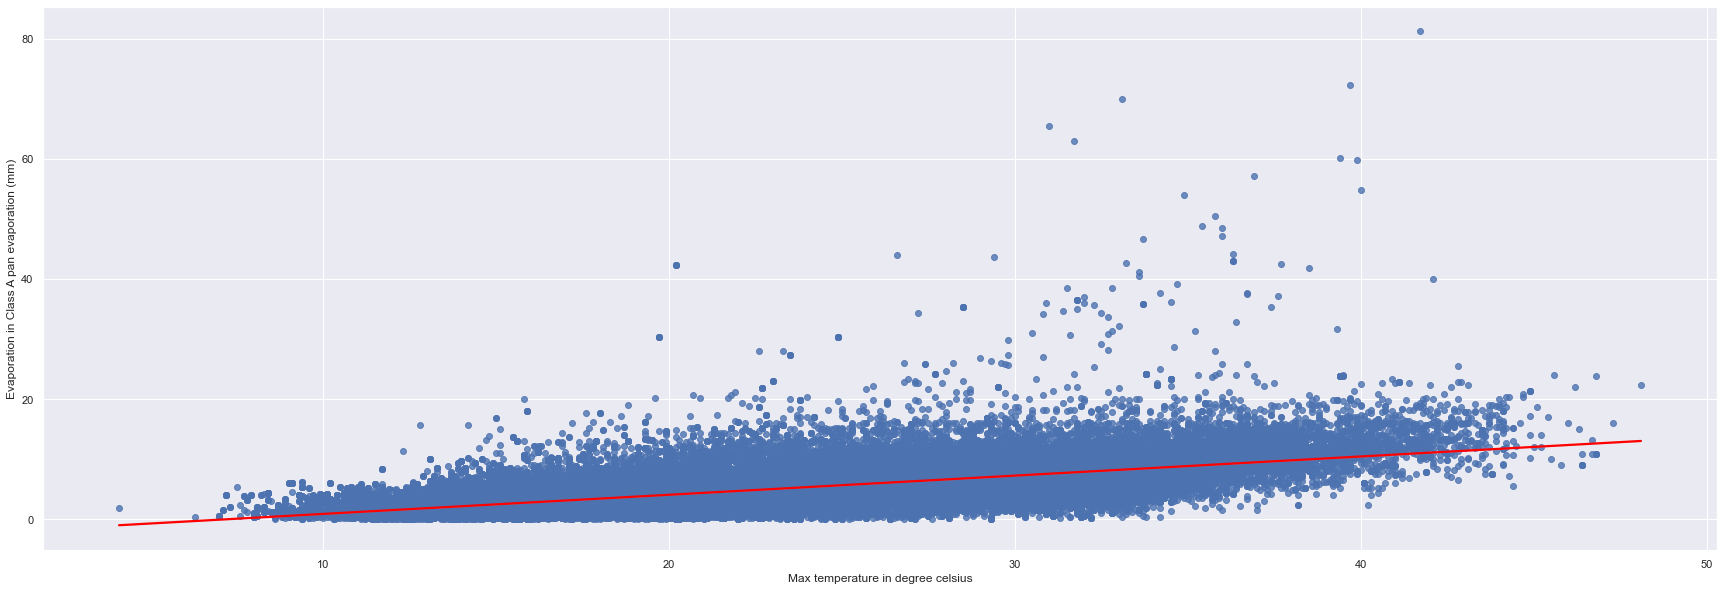

[[1.         0.62771266]
 [0.62771266 1.        ]]


In [ ]:
#绘制散点图并进行线性拟合
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
sns.regplot(x = df["maxtemp"], y = df["evaporation"], line_kws = {"color": "red"})
plt.xlabel("Max temperature in degree celsius")
plt.ylabel("Evaporation in Class A pan evaporation (mm)")
fig.set_size_inches(30, 10)
plt.show()
#相关系数r
print(np.corrcoef(df["maxtemp"].to_numpy(), df["evaporation"].to_numpy()))

可以得出, maxtemp和evaporation是正相关的. maxtemp越高, evaporation越高. 这与水在温度高的时候蒸发快的科学原理相符合. 

#### evaporation和rainfall之间的关系

猜想: evaporation越高, rainfall应当越高,即它们应当是正相关的. 

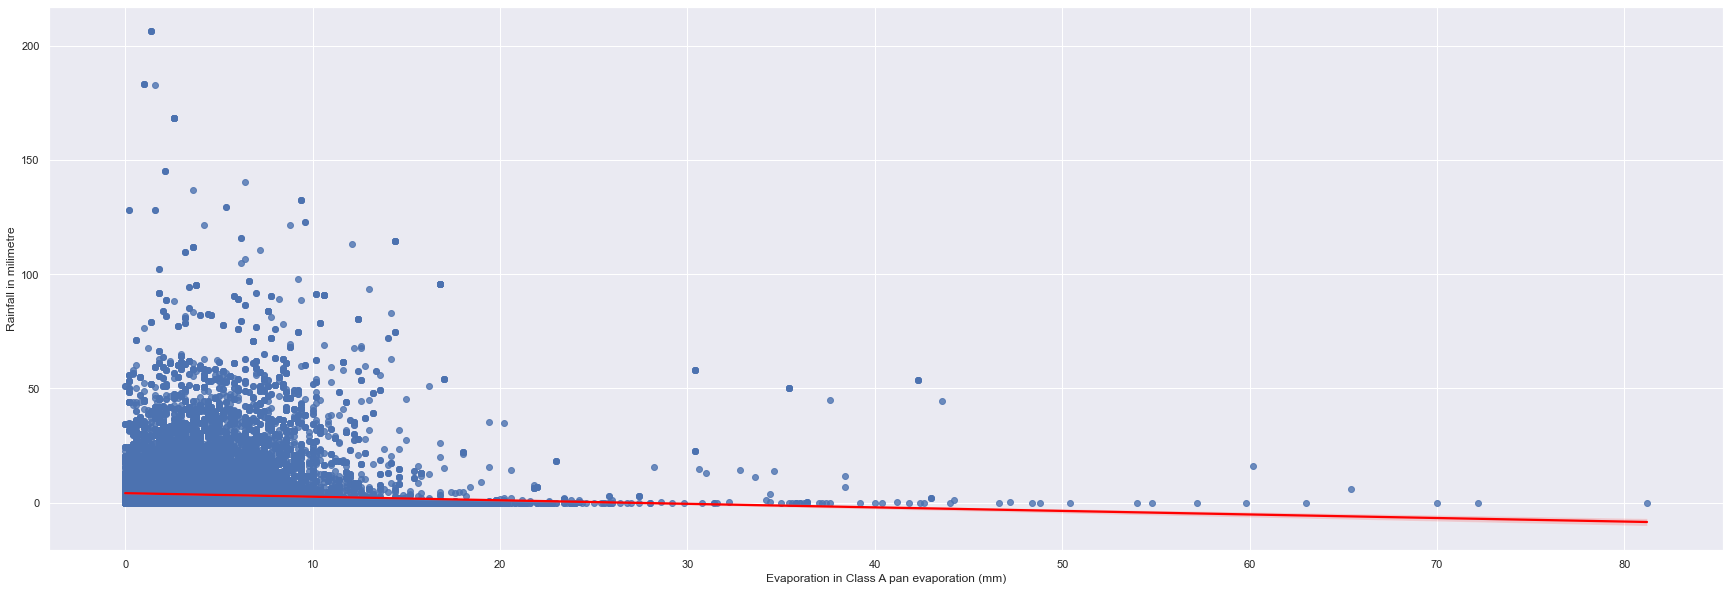

[[ 1.         -0.06106163]
 [-0.06106163  1.        ]]


In [ ]:
#绘制散点图并进行线性拟合
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
sns.regplot(x = df["evaporation"], y = df["rainfall"], line_kws = {"color": "red"})
plt.xlabel("Evaporation in Class A pan evaporation (mm)")
plt.ylabel("Rainfall in milimetre")
fig.set_size_inches(30, 10)
plt.show()
#相关系数r
print(np.corrcoef(df["evaporation"].to_numpy(), df["rainfall"].to_numpy()))

此时, 我们却只能得出evaporation和rainfall是负相关的. 这可能是由于大量的rainfall数据集中在了0到30之间. 我们出于常识, 断言了evaporation对rainfall的正面贡献. 然而, 本图告诉我们, 也许除了evaporation, 还有其他影响rainfall的因素. 

#### sunshine和temp3pm之间的关系

猜想: 考虑到3pm时阳光照射较强, sunshine和temp3pm应当是正相关的. 

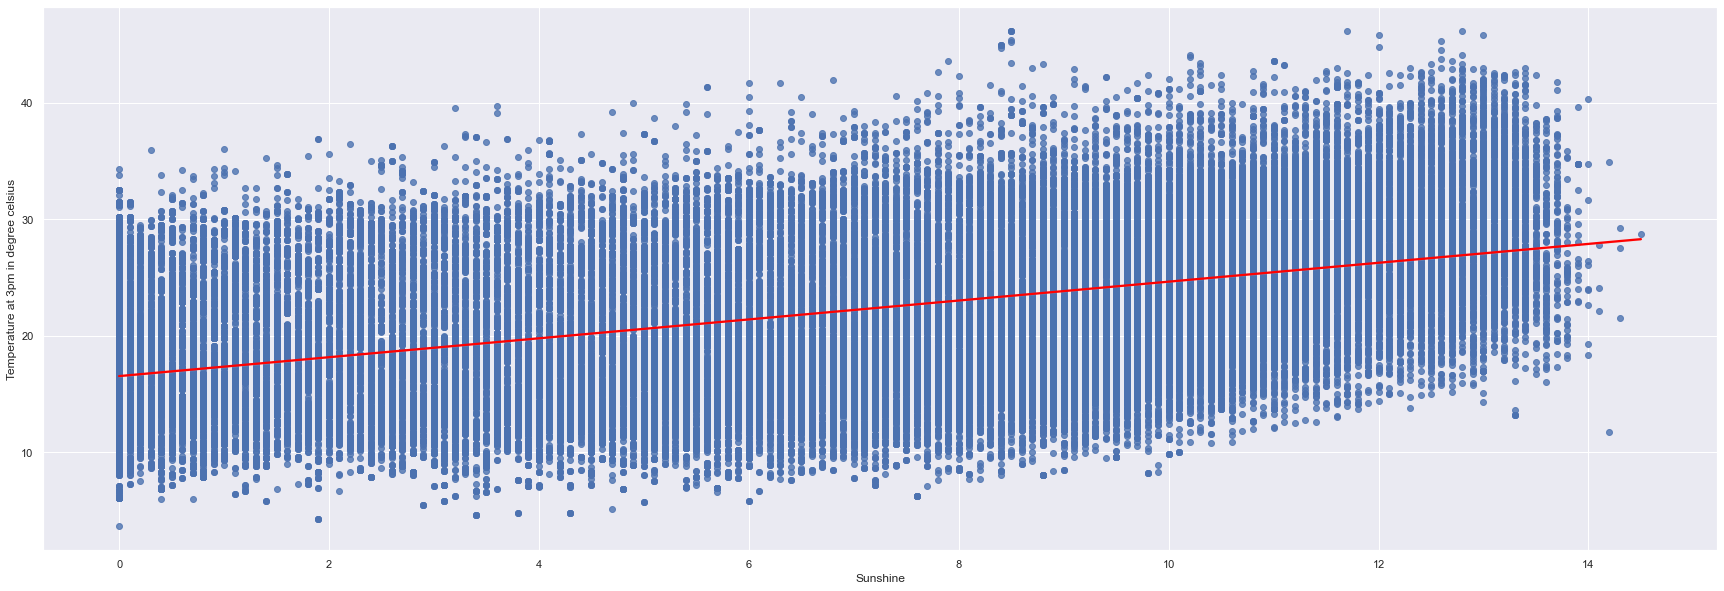

[[1.         0.46434077]
 [0.46434077 1.        ]]


In [ ]:
#绘制散点图并进行线性拟合
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
sns.regplot(x = df["sunshine"], y = df["temp3pm"], line_kws = {"color": "red"})
plt.xlabel("Sunshine")
plt.ylabel("Temperature at 3pm in degree celsius")
fig.set_size_inches(30, 10)
plt.show()
#相关系数r
print(np.corrcoef(df["sunshine"].to_numpy(), df["temp3pm"].to_numpy()))

可以看出, sunshine和temp3pm是正相关的. 由于阳光会提升大气温度, 这个结论是合理的. 

#### sunshine和mintemp之间的关系

猜想: 随着mintemp降低, sunshine应当随之降低, 即sunshine和mintemp是正相关的. 

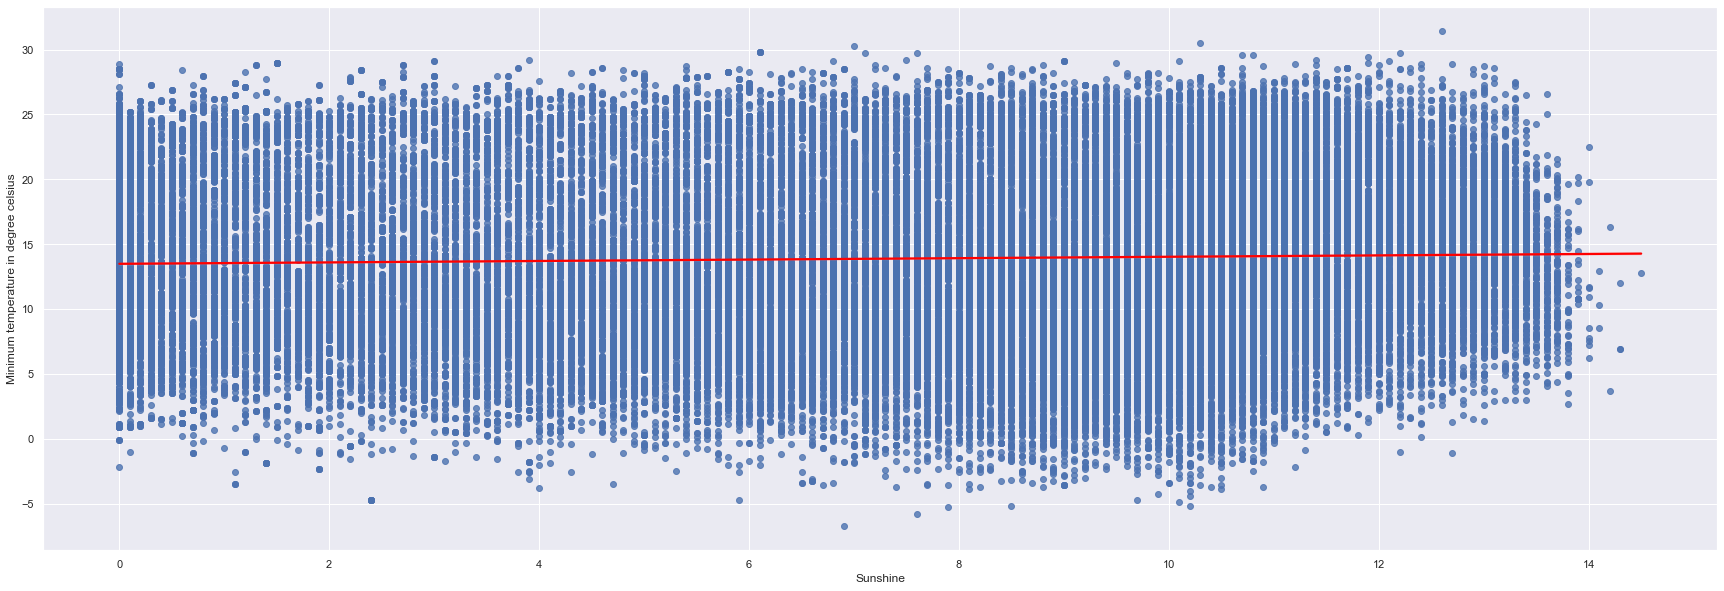

[[1.         0.03312538]
 [0.03312538 1.        ]]


In [ ]:
#绘制散点图并进行线性拟合
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
sns.regplot(x = df["sunshine"], y = df["mintemp"], line_kws = {"color": "red"})
plt.xlabel("Sunshine")
plt.ylabel("Minimum temperature in degree celsius")
fig.set_size_inches(30, 10)
plt.show()
#相关系数r
print(np.corrcoef(df["sunshine"].to_numpy(), df["mintemp"].to_numpy()))

可以得出, sunshine和mintemp是正相关的. sunshine的微小提升会带来mintemp的微小提升. 

#### mintemp和humidity9am之间的关系

猜想: 温度和湿度是负相关的, 即mintemp和humidity9am是负相关的. 

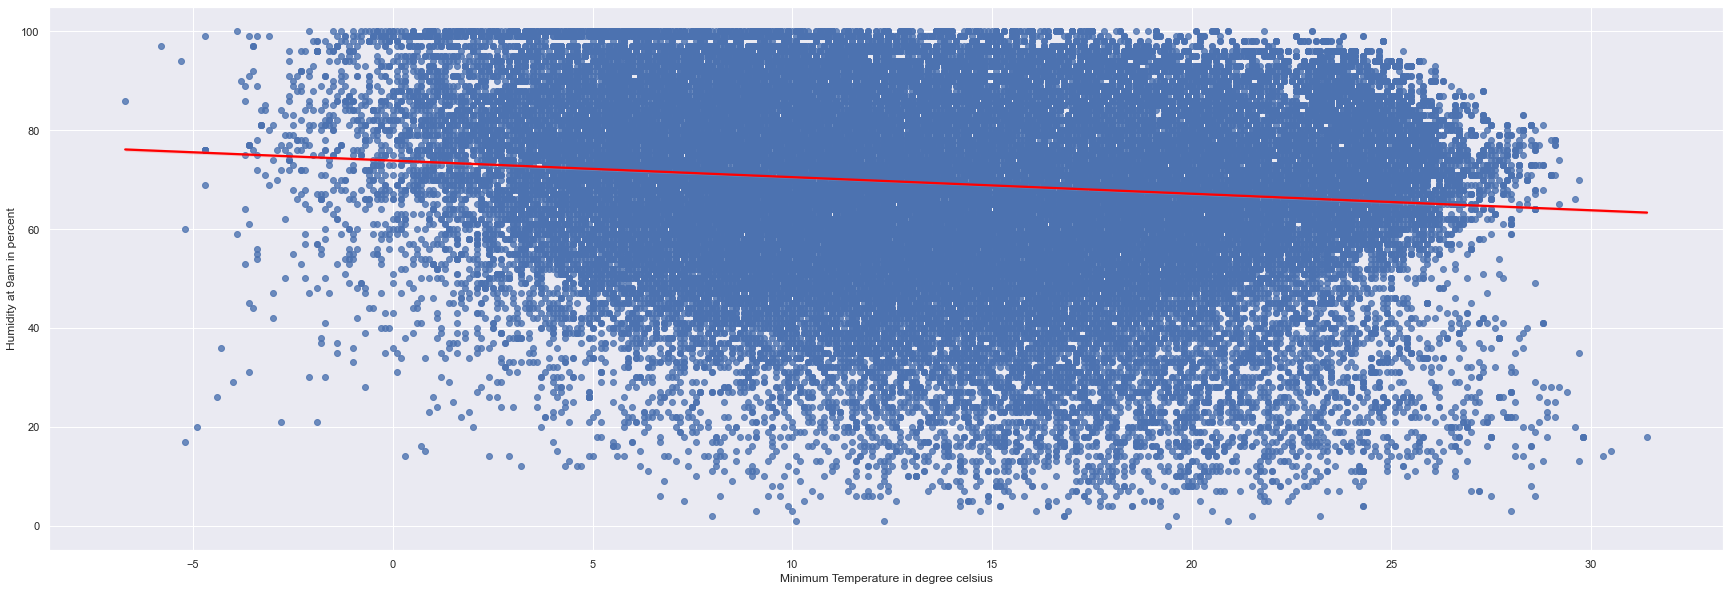

[[ 1.         -0.11902936]
 [-0.11902936  1.        ]]


In [ ]:
#绘制散点图并进行线性拟合
sns.set(style = "darkgrid")
fig, ax = plt.subplots()
sns.regplot(x = df["mintemp"], y = df["humidity9am"], line_kws = {"color": "red"})
plt.xlabel("Minimum Temperature in degree celsius")
plt.ylabel("Humidity at 9am in percent")
fig.set_size_inches(30, 10)
plt.show()
#相关系数r
print(np.corrcoef(df["mintemp"].to_numpy(), df["humidity9am"].to_numpy()))

可以看出, mintemp和humidity9am是负相关的. 

## 数据建模(Data modelling)

### 特征工程(Feature engineering)

我们在不同的变量中考察它们的相关性. 如果我们发现一对高度相关的变量, 就舍弃其中一个并保留另外一个. 这里使用**热图**(heat map)进行分析. 

<AxesSubplot:>

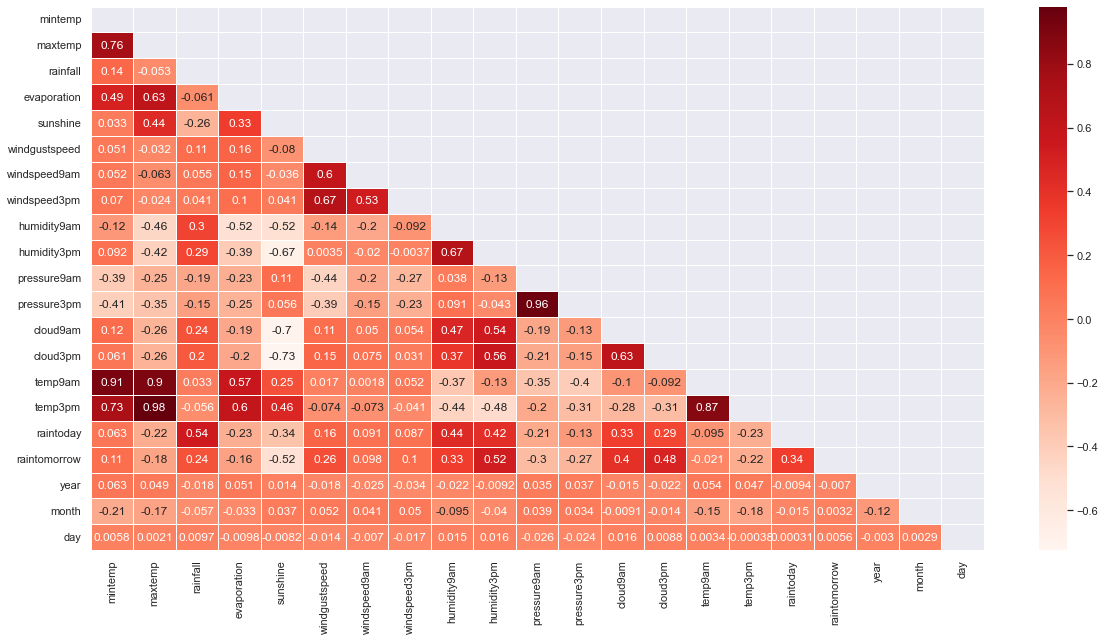

In [ ]:
#使用热图考察变量间相关性
fig, ax = plt.subplots(figsize = (20, 10))
#隐藏上三角矩阵
mask = np.triu(np.ones_like(train.corr(), dtype = np.bool))
#annot = True -> 将数据写入格中
sns.heatmap(train.corr(), annot = True, cmap = "Reds", mask = mask, linewidth = 0.5)

现在可以舍弃高度相关的变量. 

In [ ]:
train = train.drop(columns = ['temp9am', 'temp3pm', 'pressure9am'], axis = 1)
#预览变化
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87015 entries, 6049 to 87307
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location       87015 non-null  object 
 1   mintemp        87015 non-null  float64
 2   maxtemp        87015 non-null  float64
 3   rainfall       87015 non-null  float64
 4   evaporation    87015 non-null  float64
 5   sunshine       87015 non-null  float64
 6   windgustdir    87015 non-null  object 
 7   windgustspeed  87015 non-null  float64
 8   winddir9am     87015 non-null  object 
 9   winddir3pm     87015 non-null  object 
 10  windspeed9am   87015 non-null  float64
 11  windspeed3pm   87015 non-null  float64
 12  humidity9am    87015 non-null  float64
 13  humidity3pm    87015 non-null  float64
 14  pressure3pm    87015 non-null  float64
 15  cloud9am       87015 non-null  float64
 16  cloud3pm       87015 non-null  float64
 17  raintoday      87015 non-null  float64
 18  rai

In [ ]:
#提取数值特征
num_col = train.select_dtypes(include = np.number).columns.to_list()
len(num_col)

18

> 下面的每对特征, 彼此有着高度相关性. 
> + MaxTemp ~ MinTemp  
> + Pressure9am ~ Pressure3pm  
> + Temp9am ~ Temp3pm  
> + Evaporation ~ MaxTemp  
> + MaxTemp ~ Temp3pm  

In [ ]:
#提取类别特征
cat_col = train.select_dtypes(object).columns.tolist()
len(cat_col)

4

In [ ]:
#将类别特征用LabelEncoder转换为数值特征
le = LabelEncoder()
train[cat_col] = train[cat_col].astype('str').apply(le.fit_transform)

#预览变化
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87015 entries, 6049 to 87307
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   location       87015 non-null  int32  
 1   mintemp        87015 non-null  float64
 2   maxtemp        87015 non-null  float64
 3   rainfall       87015 non-null  float64
 4   evaporation    87015 non-null  float64
 5   sunshine       87015 non-null  float64
 6   windgustdir    87015 non-null  int32  
 7   windgustspeed  87015 non-null  float64
 8   winddir9am     87015 non-null  int32  
 9   winddir3pm     87015 non-null  int32  
 10  windspeed9am   87015 non-null  float64
 11  windspeed3pm   87015 non-null  float64
 12  humidity9am    87015 non-null  float64
 13  humidity3pm    87015 non-null  float64
 14  pressure3pm    87015 non-null  float64
 15  cloud9am       87015 non-null  float64
 16  cloud3pm       87015 non-null  float64
 17  raintoday      87015 non-null  float64
 18  rai

In [ ]:
train

,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,...,humidity9am,humidity3pm,pressure3pm,cloud9am,cloud3pm,raintoday,raintomorrow,year,month,day
6049,4,17.9,35.2,0.0,12.0,12.3,11,48.0,1,12,...,20.0,13.0,1004.4,2.0,5.0,0.0,0.0,2009,1,1
6050,4,18.4,28.9,0.0,14.8,13.0,8,37.0,10,10,...,30.0,8.0,1012.1,1.0,1.0,0.0,0.0,2009,1,2
6052,4,19.4,37.6,0.0,10.8,10.6,5,46.0,5,6,...,42.0,22.0,1009.2,1.0,6.0,0.0,0.0,2009,1,4
6053,4,21.9,38.4,0.0,11.4,12.2,14,31.0,14,15,...,37.0,22.0,1009.1,1.0,5.0,0.0,0.0,2009,1,5
6054,4,24.2,41.0,0.0,11.2,8.4,14,35.0,7,14,...,19.0,15.0,1007.4,1.0,6.0,0.0,0.0,2009,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140102,6,25.7,28.3,0.8,3.0,0.0,3,28.0,2,3,...,94.0,80.0,1006.2,7.0,8.0,0.0,1.0,2011,3,19
33691,20,13.1,19.7,21.0,0.6,1.9,5,31.0,7,5,...,92.0,81.0,1020.3,7.0,8.0,1.0,1.0,2009,6,21
77332,17,7.3,13.5,6.6,0.4,5.6,13,35.0,12,15,...,96.0,82.0,1022.8,8.0,8.0,1.0,1.0,2015,9,8
6148,4,16.5,20.6,14.4,6.0,0.0,0,30.0,4,5,...,97.0,76.0,1019.3,7.0,7.0,1.0,1.0,2009,4,10


至此, 所有的特征都化为了数值特征. 

### 特征选择(Feature selection)

首先舍弃预测目标变量(RainTomorrow). 

In [ ]:
x = train.drop(['raintomorrow'], axis = 1)
y = train['raintomorrow']

然后, 用K Best方法进行特征选择. 

In [ ]:
#score_func = f_classif -> 评价特征方式为方差分析(Analysis of Variance, ANOA)
fs = SelectKBest(score_func = f_classif, k = 19)
X_selected = fs.fit_transform(x, y)
print(X_selected.shape)

(87015, 19)


In [ ]:
#获取特征筛选结果
cols = fs.get_support(indices = True)
#选取上述列的所有行
X_new = x.iloc[:, cols]

#预览变化
X_new

,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,humidity9am,humidity3pm,pressure3pm,cloud9am,cloud3pm,raintoday,year
6049,4,17.9,35.2,0.0,12.0,12.3,11,48.0,1,12,6.0,20.0,20.0,13.0,1004.4,2.0,5.0,0.0,2009
6050,4,18.4,28.9,0.0,14.8,13.0,8,37.0,10,10,19.0,19.0,30.0,8.0,1012.1,1.0,1.0,0.0,2009
6052,4,19.4,37.6,0.0,10.8,10.6,5,46.0,5,6,30.0,15.0,42.0,22.0,1009.2,1.0,6.0,0.0,2009
6053,4,21.9,38.4,0.0,11.4,12.2,14,31.0,14,15,6.0,6.0,37.0,22.0,1009.1,1.0,5.0,0.0,2009
6054,4,24.2,41.0,0.0,11.2,8.4,14,35.0,7,14,17.0,13.0,19.0,15.0,1007.4,1.0,6.0,0.0,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140102,6,25.7,28.3,0.8,3.0,0.0,3,28.0,2,3,11.0,19.0,94.0,80.0,1006.2,7.0,8.0,0.0,2011
33691,20,13.1,19.7,21.0,0.6,1.9,5,31.0,7,5,9.0,24.0,92.0,81.0,1020.3,7.0,8.0,1.0,2009
77332,17,7.3,13.5,6.6,0.4,5.6,13,35.0,12,15,15.0,22.0,96.0,82.0,1022.8,8.0,8.0,1.0,2015
6148,4,16.5,20.6,14.4,6.0,0.0,0,30.0,4,5,7.0,9.0,97.0,76.0,1019.3,7.0,7.0,1.0,2009


现在, 我们只需要处理上表中的数据. 

### 缩放和分割

#### 分割(Splitting)

我们将数据集分割为**训练集**(training set)和**测试集**(test set).

In [ ]:
trainX, testX, trainY, testY = train_test_split(X_new, y, test_size = 0.2, random_state = 999)
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(69612, 19)
(17403, 19)
(69612,)
(17403,)


#### 缩放(Scaling)

通过**标准差标准化**(standard scale)来进行数据的标准化. 

In [ ]:
#确定scaler
std_scaler = StandardScaler()

#训练并标准化
X_train = std_scaler.fit_transform(trainX)
X_test = std_scaler.transform(testX)

### 模型评估, 对比与选择

#### 模型评估(Model evaluation)

> 待评估的模型:  
> + 线性回归(Logistic Regression);  
> + XGBoost;  
> + 随机森林(Random Forest).  

在评估之前, 我们需要一个记录各模型消耗时间的计时函数. 

In [ ]:
#计时函数
def timer(start_time = None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\nTime taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

##### 线性回归(Logistic Regression)

> 优点: 在分析数个独立的变量对于单个结果变量的影响时最有用;  
> 缺点: 只有当预测变量为**二元**(binary)时才适用, 并且认为所有用于预测的变量互相独立且没有缺失值. 

对线性回归模型运用**网格搜索**(grid search)以进行**参数调优**(parameter tuning).

In [ ]:
logRegTrain_cv = LogisticRegression()
#solver: 对逻辑回归损失函数的优化方法, 其中:
#newton-cg: 共轭梯度法, 利用损失函数二阶导数矩阵即海森矩阵来迭代优化损失函数;
#lbfgs: 内存受限的 BFGS 算法, 用损失函数二阶导数矩阵即海森矩阵来迭代优化损失函数;
#liblinear: 使用了坐标轴下降法来迭代优化损失函数.
solvers=['newton-cg','lbfgs','liblinear']
#penalty: 正则化选择参数
penalty=['l1','l2']
#C: 惩罚系数
c_values=[100, 10, 1.0, 0.1, 0.01]

#网格搜索
grid = dict(solver = solvers, penalty = penalty, C = c_values)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
grid_search = GridSearchCV(estimator = logRegTrain_cv, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy', error_score = 0)
#开始计时
start_time = timer(None)
grid_result = grid_search.fit(X_train, trainY)
#停止计时
timer(start_time)

#结果
print("Best parameters: ",grid_result.best_params_)
print("Model accuracy: ",grid_result.best_score_)


Time taken: 0 hours 2 minutes and 26.47 seconds.
Best parameters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Model accuracy:  0.7990193224798791


对线性回归模型运用网格搜索给出的最佳参数. 

In [ ]:
#使用上述最佳参数
logRegTrain_grid = LogisticRegression(C = 0.1, penalty = "l1", solver = 'liblinear')
#训练模型
logRegTrain_grid.fit(X_train, trainY)
#进行预测
pred_grid = logRegTrain_grid.predict(X_test)

#评价指标
r2 = r2_score(pred_grid, testY)
LR_rmse = sqrt(mean_absolute_error(pred_grid, testY))
print("Mean squared error: %.4f"
      % metrics.mean_squared_error(pred_grid, testY))
print("Root mean absolute error: ", LR_rmse)
print("Mean absolute error: ", mean_absolute_error(pred_grid, testY))
print("R2 score: ", r2)
print("F1 score: ", f1_score(pred_grid, testY))
print("Training accuracy score: ", logRegTrain_grid.score(X_train, trainY))
print("Testing accuracy score: ", accuracy_score(pred_grid, testY))
print(classification_report(testY, pred_grid))

Mean squared error: 0.1994
Root mean absolute error:  0.44659642964372465
Mean absolute error:  0.19944837097052232
R2 score:  0.20085759043966278
F1 score:  0.7935280471120101
Training accuracy score:  0.799014537723381
Testing accuracy score:  0.8005516290294776
              precision    recall  f1-score   support

         0.0       0.80      0.81      0.81      8936
         1.0       0.80      0.79      0.79      8467

    accuracy                           0.80     17403
   macro avg       0.80      0.80      0.80     17403
weighted avg       0.80      0.80      0.80     17403



##### XGBoost

> + 优点: 需要较少的特征工程, **解释快**(fast to interpret), 在应对大规模的数据集时效果良好, 且不容易过拟合;  
> + 缺点: 如果参数调优欠佳, 可能会导致过拟合, 且由于有过多的**超参数**(hyperparameter), 难以调优.  

对XGBoost模型运用网格搜索以进行参数调优.

In [ ]:
params = {
        #min_child_weight: 最小叶子节点样本权重和, 用于避免过拟合
        'min_child_weight': [1, 5, 10],
        #gamma: 节点分裂所需的最小损失函数下降值, 值越大, 算法越保守
        'gamma': [0.5, 1, 1.5, 2, 5],
        #subsample: 对于每棵树，随机采样的比例, 值约小, 算法越保守, 避免过拟合
        'subsample': [0.6, 0.8, 1.0], 
        #colsample_bytree: 用来控制每棵随机采样的列数的占比(每一列是一个特征)
        'colsample_bytree': [0.6, 0.8, 1.0],
        #max_depth: 树的最大深度, 值越大，模型会学到更具体更局部的样本
        'max_depth': [3, 4, 5]
        }
xgb = XGBClassifier(learning_rate = 0.02, n_estimators = 600, objective = 'binary:logistic',
                    silent = True, nthread = 1)
folds = 5
param_comb = 5
skf = StratifiedKFold(n_splits = folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(xgb, param_distributions = params, n_iter = param_comb, 
                                   scoring = 'roc_auc', n_jobs = 4, cv = skf, verbose = 3, random_state = 1001)
#开始计时
start_time = timer(None)
rf_result = random_search.fit(X_train, trainY)
#停止计时
timer(start_time)

#结果
print("Best parameters: ",rf_result.best_params_)
print("Model accuracy: ",rf_result.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[19:14:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:14:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Time taken: 0 hours 6 minutes and 13.27 seconds.
Best parameters:  {'subsample': 0.6, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 1.5, 'colsample_bytree': 0.8}
Model accuracy:  0.9154592875065919


对XGBoost模型运用网格搜索给出的最佳参数. 

In [ ]:
#使用上述最佳参数
xgb = XGBClassifier(subsample = 0.6, min_child_weight = 1, max_depth = 5, gamma = 1.5, colsample_bytree = 0.8)
#训练模型
xgb.fit(X_train, trainY)
#进行预测
xgb_pred = xgb.predict(X_test)

#评价指标
xgb_r2 = r2_score(xgb_pred, testY)
xgb_rmse = sqrt(mean_absolute_error(xgb_pred, testY))
print("Mean squared error: %.4f"
      % metrics.mean_squared_error(xgb_pred, testY))
print("Root mean absolute error: ", xgb_rmse)
print("Mean absolute error: ", mean_absolute_error(xgb_pred, testY))
print("R2 score: ", xgb_r2)
print("F1 score: ", f1_score(xgb_pred, testY))
print("Testing accuracy score: ", accuracy_score(xgb_pred, testY))
print(classification_report(testY, xgb_pred))

[19:15:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Mean squared error: 0.1461
Root mean absolute error:  0.38226199321191606
Mean absolute error:  0.14612423145434694
R2 score:  0.41547481720375645
F1 score:  0.8524000232166695
Testing accuracy score:  0.8538757685456531
              precision    recall  f1-score   support

         0.0       0.87      0.84      0.86      8936
         1.0       0.84      0.87      0.85      8467

    accuracy                           0.85     17403
   macro avg       0.85      0.85      0.85     17403
weighted avg       0.85      0.85      0.85     17403



##### 随机森林(Random Forest)

> + 优点: 减少过拟合, 并且**随机森林分类器**(random forest classifier)在大多数情况下比**决策树**(decision tree)更加精确.  
> + 缺点: **实时预测**(real time prediction)速度慢, 难以实施, 并且算法复杂. 

对随机森林模型运用网格搜索以进行参数调优.

In [ ]:
#定义模型和参数
rfm = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']

#网格搜索
grid = dict(n_estimators = n_estimators, max_features = max_features)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
rf_grid_search = GridSearchCV(estimator = rfm, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy', error_score = 0)
#开始计时
start_time = timer(None)
rf_grid_result = rf_grid_search.fit(X_train, trainY)
#停止计时
timer(start_time)

#结果
print("Best parameters: ", rf_grid_result.best_params_)
print("Model accuracy: ", rf_grid_result.best_score_)


Time taken: 0 hours 41 minutes and 29.41 seconds.
Best parameters:  {'max_features': 'sqrt', 'n_estimators': 1000}
Model accuracy:  0.9432856266008002


对随机森林模型运用网格搜索给出的最佳参数. 

In [ ]:
#使用上述最佳参数
rfm = RandomForestClassifier(n_estimators = 1000, max_features = 'log2')
#训练模型
rfm.fit(X_train, trainY)
#进行预测
rfm_pred = rfm.predict(X_test)

#评价指标
rfm_r2 = r2_score(rfm_pred, testY)
rfm_rmse = sqrt(mean_absolute_error(rfm_pred, testY))
print("Mean squared error: %.4f"
      % metrics.mean_squared_error(rfm_pred, testY))
print("Root mean absolute error: ", rfm_rmse)
print("Mean absolute error: ", mean_absolute_error(rfm_pred, testY))
print("R2 score: ", rfm_r2)
print("F1 score: ", f1_score(rfm_pred, testY))
print("Testing accuracy score: ", accuracy_score(rfm_pred, testY))
print(classification_report(testY, rfm_pred))

Mean squared error: 0.0520
Root mean absolute error:  0.2280406286163026
Mean absolute error:  0.05200252829971844
R2 score:  0.7917381932195711
F1 score:  0.9481998740770419
Testing accuracy score:  0.9479974717002816
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95      8936
         1.0       0.92      0.98      0.95      8467

    accuracy                           0.95     17403
   macro avg       0.95      0.95      0.95     17403
weighted avg       0.95      0.95      0.95     17403



#### 模型对比

> 一些对比特征:
> + **均方误差**(mean squared error),   
    **均方根绝对误差**(root mean absolute error),  
    **平均绝对误差**(mean absolut error): 代表了预测值与真实值的匹配程度;  
> + **可决系数**(coefficient of determination, $r^2$): 代表了**反应变量**(dependent variable)由于**解释变量**(explanatory variable)的变化而变化的程度;

> **分类指标报告**(classification report)是另外一种衡量分类模型表现好坏的方法.  
> 首先给出一些定义: 
> - **真正**(true positive, TP): 判断为正, 且判断正确(实际为正);
> - **真负**(true negative, TN): 判断为负, 且判断正确(实际为负);
> - **假正**(false positive, FP): 判断为正, 但判断错误(实际为负);
> - **假负**(frue negative, FN): 判断为负, 但判断错误(实际为正);  

> 于是我们有: 
> + **精确度**(precision): 代表判断为正结果的可信度. 它的定义为:$$P=\frac{TP}{TP+FP},$$即真正结果数与所有判断为正结果数之比.  
> + **召回率**(recall): 代表判断为正的结果的齐全度. 它的定义为:$$R=\frac{TP}{TP+FN},$$即真正结果数与所有实际为正结果数之比. 
> + **$F_1$值**($F_1$ score): 是二元分类准确度的度量. 它是精确度$P$与召回率$R$的**调和平均**(harmonic mean), 即$$\frac{2}{F_1}=\frac{1}{P}+\frac{1}{R},\\F_1=\frac{2PR}{P+R}.$$$F_1$值为1时达到最佳, 此时有完美的精确度和召回率; $F_1$值为0时则最差.
> + **支持度**(support): 一个分类在数据集中实际出现的次数. 

现在, 我们需要根据**分类准确率**(accuracy score), 平均绝对误差(MAE)和执行时间来判断哪个模型表现最好.  
($F_1$值也可以作为一个判据, 但由于我们已经将不平衡的数据集变得平衡, 用分类准确率代替它是合理的.)

Text(0.5, 1.0, 'Model Comparison: Accuracy for execution')

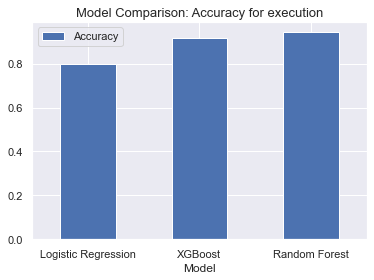

In [ ]:
accuracy_scores = [grid_result.best_score_, rf_result.best_score_, rf_grid_result.best_score_]

model_data = {'Model': ['Logistic Regression', 'XGBoost', 'Random Forest'],
              'Accuracy': accuracy_scores}
data = pd.DataFrame(model_data)

ax = data.plot.bar(x = 'Model', y = 'Accuracy', rot = 0)
ax.set_title('Model Comparison: Accuracy for execution', fontsize = 13)

> + 分类准确率: $$随机森林_{(0.95)} > \text{XGBoost}_{(0.85)} > 线性回归_{(0.80)};$$
> + 平均绝对误差(MAE): $$随机森林_{(0.05)} < \text{XGBoost}_{(0.15)} < 线性回归_{(0.20)};$$
> + 执行时间: $$线性回归_{(02'26''47)} < \text{XGBoost}_{(06'13''27)} \ll 随机森林_{(41'29''41)}.$$

### 3.4.3 模型选择

由上面的对比, 我们容易得出, 随机森林模型比另外两个模型的表现都要好很多. 因此, 在条件允许的情况下, 我们将选择网格搜索参数调优过的随机森林模型.  
然而, 使用随机森林模型的代价相对来说也是最大的. 它的执行时间和消耗资源都是远远大于另外两个模型的. 因此, 如果要将这一点纳入考虑的话, 也可以转用XGBoost. 它在运行时间和消耗资源方面较随机森林优势巨大, 且有着较高的准确率. 

# 4. 模型部署(Model deployment)

In [ ]:
#定义随机森林模型并使用最佳参数
rfm = RandomForestClassifier(n_estimators = 1000, max_features = 'log2')
#训练模型
rfm.fit(X_train, trainY)
#进行预测
preds = rfm.predict(X_test)
#创建预测字典
list_id = np.arange(1, len(preds) + 1)
preds_dict = {'ID':list_id, 'raintomorrow': preds.flatten()}
#写入本地.csv文件
preds_df = pd.DataFrame(preds_dict)
preds_df.to_csv('Rainfall_predictions.csv', index = False, sep = ',')
#输出预测结果
count0 = 0
count1 = 1
for i in preds:
     if i == 0:
         count0 += 1
     else:
         count1 += 1
print("The number of days without rain: ", count0)
print("The number of rain days: ", count1)

The number of days without rain:  8392
The number of rain days:  9012
